In [1]:
# Set up sys.path and import needed packages.
import _preamble

import numpy as np
import matplotlib.pyplot as plt

from pmte import estimation, tapers
import helpers

In [2]:
# Set basic parameters.
M = 120  # Number of images
W = 1 / 16  # Bandwidth

# Initialize PRNG.
rng = np.random.default_rng(0)

In [3]:
# Load M sample images from the EMPIAR-100028 dataset.
signal, projection = helpers.load_exp_images(M)

# Extract size of the experimental images.
N = signal.shape[-1]

In [4]:
# Since we don't have access to the true power spectral densities (PSDs) of the
# experimental images, we subtract the estimated projection image and estimate
# the power spectrum of the difference. If the projection estimate is reasonably
# accurate, the residual should consist only of noise. Of course, this is only
# possible if we already have estimated projections, which is not the case for
# unprocessed experimental data.

h = tapers.tensor_tapers((N, N), W)
psd_true = estimation.multitaper(signal - projection, h)

In [5]:
# Define functions for estimating the density using the three methods for a
# given mask.


def est_mper(x, mask):
    x_mper = estimation.periodogram(x * mask, 2)
    x_mper *= N ** 2 / np.sum(mask)

    return x_mper


def est_pmt(x, mask):
    h_pmt = tapers.proxy_tapers(mask, W, rng=rng)
    x_pmt = estimation.multitaper(x, h_pmt)

    return x_pmt


def est_cmt(x, mask):
    h_cmt = tapers.corner_tapers(mask, W)
    x_cmt = estimation.multitaper(x, h_cmt)

    return x_cmt

In [6]:
# Estimate the density for masks corresponding to various radii. From these, we
# compute the mean squared error (MSE) compared to the density estimated
# obtained from the residual images after subtracting the estimated projections
# (see above).

radii = np.arange(36, 144 + 1, 12)

methods = {"mper": est_mper, "cmt": est_cmt, "pmt": est_pmt}

mses = {name: [] for name in methods}

print("%-20s%8s%15s" % ("Estimator", "Radius", "MSE"))

for radius in radii:
    mask = ~helpers.disk_mask(N, radius)

    for name, method in methods.items():
        psd_est = method(signal, mask)

        mse = np.mean(np.abs(psd_est - psd_true) ** 2)

        print("%-20s%8d%15e" % (name, radius, mse))

        mses[name].append(mse)

Estimator             Radius            MSE
mper                      36   1.549290e+01
cmt                       36   9.198795e-02
pmt                       36   2.881294e-01
mper                      48   1.460459e+01
cmt                       48   3.833710e-02
pmt                       48   2.130741e-01
mper                      60   1.365876e+01
cmt                       60   3.929345e-02
pmt                       60   1.395594e-01
mper                      72   1.276413e+01
cmt                       72   4.099471e-02
pmt                       72   7.625897e-02
mper                      84   1.185682e+01
cmt                       84   5.294156e-02
pmt                       84   3.652345e-02
mper                      96   1.095814e+01
cmt                       96   7.561178e-02
pmt                       96   2.233870e-02
mper                     108   1.040558e+01
cmt                      108   9.409651e-02
pmt                      108   2.524154e-02
mper                     120   1

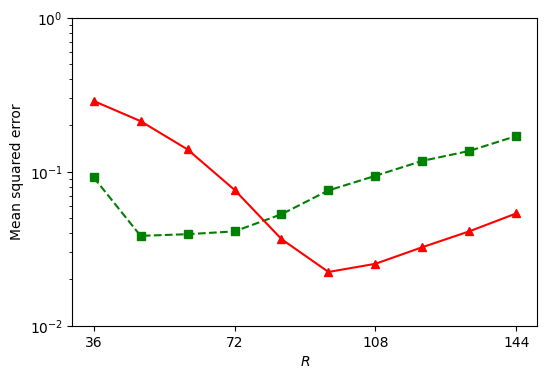

In [7]:
# Plot Figure 11 in the paper.
plt.figure(figsize=(6, 4))
plt.semilogy(radii, mses["cmt"], "s--g", radii, mses["pmt"], "^-r")
plt.ylim((1e-2, 1e0))
plt.xticks([36, 72, 108, 144])
plt.xlabel("$R$")
plt.ylabel("Mean squared error")
plt.show(block=False)

In [8]:
# Extract some useful metrics from the data and print them.
min_mse_mper = np.min(mses["mper"])
min_mse_cmt = np.min(mses["cmt"])
min_mse_pmt = np.min(mses["pmt"])

argmin_mse_pmt = radii[np.argmin(mses["pmt"])]

print("Radius for lowest MSE with proxy tapers: %d" % (argmin_mse_pmt,))

mse_factor_mper = min_mse_mper / min_mse_pmt
mse_factor_cmt = min_mse_cmt / min_mse_pmt

print("MSE reduction vs. masked periodogram: %f" % (mse_factor_mper,))
print("MSE reduction vs. corner multitaper: %f" % (mse_factor_cmt,))

Radius for lowest MSE with proxy tapers: 96
MSE reduction vs. masked periodogram: 435.623936
MSE reduction vs. corner multitaper: 1.716174


---

In [9]:
# Save data for figure generation.
helpers.save_table("cryo_exp", np.round(radii), mses["mper"], mses["cmt"], mses["pmt"])

results = {
    "min_mse_mper": float(min_mse_mper),
    "min_mse_cmt": float(min_mse_cmt),
    "min_mse_rt": float(min_mse_pmt),
    "argmin_mse_rt": float(argmin_mse_pmt),
    "mse_factor_mper": float(mse_factor_mper),
    "mse_factor_cmt": float(mse_factor_cmt),
}

helpers.save_dictionary("cryo_exp", results)